IBMQ Providers: [<IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>]
Dynamic Providers: QasmSimulator('qasm_simulator')
Counts for Qubit Pairs out of 8192 shots: {'0001': 428, '0111': 2269, '0101': 5495}


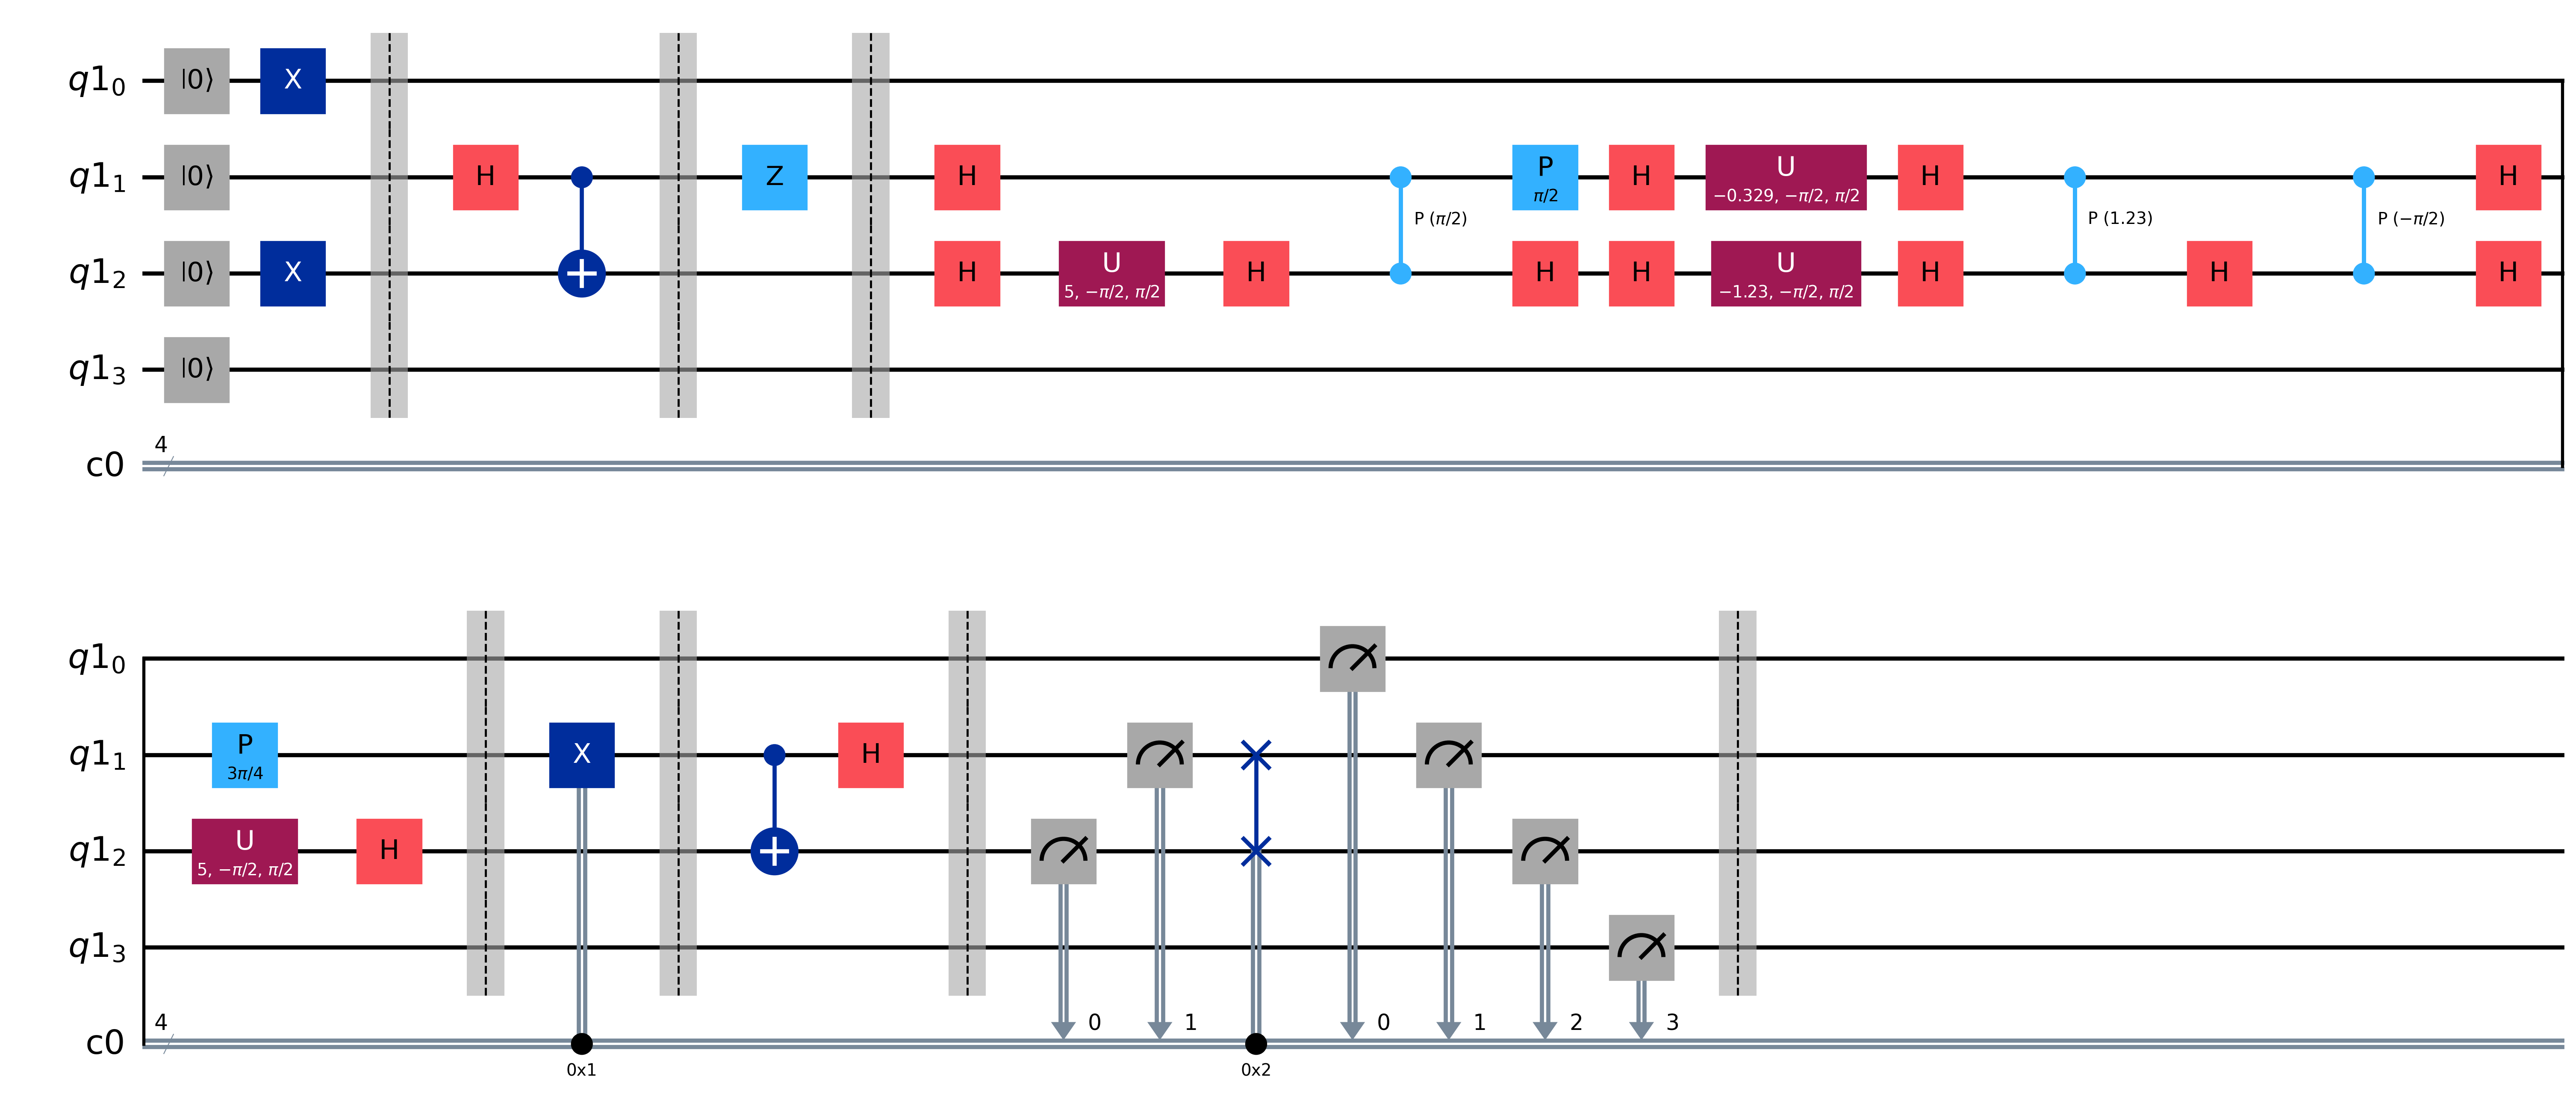

In [1]:
#--------------------------------------------------------------------------------------------
# Quantum simulation of a quantum field lens coding algorithm with entanglement scaling
# between a multi-well (barrier) interaction potential of internal system B interacting and 
# external system A.
# Created by: Philip B. Alipour, Supervisor: T. A. Gulliver, at the University of Victoria,
# Dept. ECE, Victoria BC, Canada. 
# Code updated based on Qiskit 2023--2024 changes specified in code comments below. 
# Side-notes: You can also run code with the right packages installed in pipx or python.
# Examples of changes can be found on e.g., 
# https://docs.quantum.ibm.com/api/migration-guides/qiskit-1.0-installation and 
# https://docs.quantum.ibm.com/api/migration-guides/qiskit-1.0-features  
# follow the link to fix 'deprecated release' lines, use 
# <pip install "qiskit-aer>=0.11.0"> 
# and <pip install qiskit-ibm-provider> after activating your qiskit virtual environment in 
# shell.
#------------------------------------------------------------------------------------------
# Import the QISKit SDK 
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import *
from qiskit_aer import Aer  # 2024 update... from its deprecated release.
from colorama import Fore  # For colored text messages.
#-----------------------------------------------------------------------------------------
# Newly added package in 2023/2024, the U3 gate has been renamed the U gate.
# from https://quantum-computing.ibm.com/composer/docs/iqx/operations_glossary
# and for cu1 gate to recreate this gate, add the control modifier to the phase gate 
# (formerly the U1 gate); (older version of Qiskit cu1, now cp)
# U3 should be renamed just U as it is an arbitrary single-qubit gate.
# CU1 should be renamed Cphase or CP depending on above. For more, visit
# https://github.com/Qiskit/qiskit-terra/issues/4106
#-----------------------------------------------------------------------------------------
from math import pi
from qiskit.compiler import transpile, assemble # In 2024, execute now is renamed to transpile. 
from qiskit.visualization import *
from qiskit.providers.backend import Backend # Specify backend device for data processing
from qiskit_ibm_provider import IBMProvider  # 2024 update... from its deprecated release. 

def qdf_circuit():  # Function to compose/build a QDF circuit.
 global qc    # Instantiate qc as a global variable to represent the quantum circuit.  
 # Set your API Token. IBMQ.enable_account ('API Token') Create a Quantum Register with 
 # 4 qubits.
 q = QuantumRegister(4)
 
 # Create a Classical Register with 4 bits.
 c = ClassicalRegister(4) # as _b in Fig. 6 of Ref. [1]
 
 # Create a Quantum Circuit.
 qc = QuantumCircuit(q, c)

 #-----------------------------------------------------------------------------------------
 # Implementation of Superdense Coding
 #-----------------------------------------------------------------------------------------
 # State initialization on 4 qubits in the z-basis in the |0> state.
 qc.reset(q[0])
 qc.reset(q[1])
 qc.reset(q[2])
 qc.reset(q[3])
 qc.x(q[0])
 qc.x(q[2]) 
 qc.barrier(range(4)) # Barrier to indicate physical barriers between systems A and B
                     # particles in communication.
 qc.h(q[1]) 
 qc.cx(q[1], q[2])
 qc.barrier(range(4))
 qc.z(q[1])   # Current state and encoded in the message through QFT.
 #qc.x(q[1])  # Current message encoded in the superdense coding scheme
 qc.barrier(range(4))
 
 # Time step = 1. Time evolution of potential energy part of the Ising model (spin
 # configuration tending to ground state or magnetization M>0) relative to kappaPhi
 # implementation.
 qc.h(q[2])
 qc.u(5,-pi/2,pi/2,q[2])
 qc.h(q[2])
 
 #---------------------------------------------------------------------------------------
 # Entanglement Encoder Implementation
 #---------------------------------------------------------------------------------------
 # Two-qubit Inverse Quantum Fourier Transform (QFT^-1)
 qc.h(q[1])
 qc.cp(pi/2, q[2], q[1])
 qc.h(q[2])
 
 # Time evolution of kinetic Ising model (kinetic energy part satisfying magnetization
 # value M=0)
 qc.p(pi/2, q[1])
 qc.h(q[1])
 qc.u(-(pi**2)/30, -pi/2, pi/2, q[1])
 qc.h(q[1])
 qc.h(q[2])
 qc.u(-(pi**2)/8, -pi/2, pi/2, q[2])
 qc.h(q[2])
 qc.cp((pi**2)/8, q[2], q[1])
 
 # Two-qubit Quantum Fourier Transform (QFT)
 qc.h (q[2])
 qc.cp (-pi/2, q[2], q[1])
 qc.h (q[1])
 
 # Time evolution of potential energy part 
 qc.p(3*pi/4, q[1])
 qc.h (q[2])
 qc.u (5, -pi/2, pi/2, q[2])
 qc.h (q[2])
 qc.barrier(range(4))
 
 #------------------------------------------------------------------------------------
 # Continuation of the superdense code algorithm. Remove IF statement for real quantum
 # computers when enabling one of the backends after 'qasm_simulator' below
 #------------------------------------------------------------------------------------
 qc.x(q[1]).c_if(c, 1)  # IF statement , as if the prize is spotted via Eve or the
 # audience, ask Bob to decide to win the prize or a prize of lesser quality or energy
 # value; flipping condition for Alice to cloak the prize is 0 as opposed to 1 or 2 in
 # decimal. Remove IF statement when testing on a quantum computer and not a simulator.
 qc.barrier(range(4))
 qc.cx(q[1], q[2])
 qc.h(q[1])
 qc.barrier(range(4))
 qc.measure(q[2], c[0])  # Qubit 2 is in state |0>
 qc.measure(q[1], c[1])  # Qubit 1 is in state |1>
 
 # Remove IF statement for real quantum computers when enabling one of the backends after
 # 'qasm_simulator' below qc.swap(q[1],q[2]).c_if(c, 1) # SWAP gate is used if
 # condition c=1 or 01 in binary.
 qc.swap(q[1],q[2]).c_if(c, 2)   # SWAP gate is used if condition c=2 or 10 in binary
 qc.measure(q, c)  # Map the quantum measurement to the classical bits
 qc.barrier(range(4))
 
 global counts_exp   # Used to plot P results for N shots run on the QDF circuit.
 #------------------------------------------------------------------------------------
 # Choose backend, number of shots and the plotting of histogram.
 #------------------------------------------------------------------------------------
 my_provider = IBMProvider() # Previously was IBMQ.load_account().
 print(Fore.GREEN + "IBMQ Providers:" + Fore.YELLOW, my_provider.backends())
 ibmq_pick = my_provider.get_backend('ibmq_qasm_simulator') # To run on without dynamic support.
 dyn_pick = Aer.get_backend('qasm_simulator') # The device to run on dynamically... 2024 update. 
 print(Fore.GREEN + "Dynamic Providers:"+ Fore.YELLOW, dyn_pick)
 #ibmq_pick = provider.get_backend('simulator_statevector')
 #ibmq_pick = my_provider.get_backend('ibmq_athens') # this machine was recently retired
 #ibmq_pick = my_provider.get_backend('ibmq_16_melbourne') # this machine was recently retired
 shots = 8192 # Number of shots to run the program (experiment); maximum is 8192 shots.
 job_exp = dyn_pick.run(qc, shots = shots) # 2024 update...
 result = job_exp.result()
 print(Fore.GREEN + f'Counts for Qubit Pairs out of {shots} shots:' + Fore.RED, result.get_counts(qc))
 counts_exp = (result.get_counts(qc))
 
 #--- The above code snippet is the old version limited to counts ratio to maximum number 
 # of shots = 8192 resulting to plot probabilities in older Qiskit versions (as 
 # presented in our method article, Ref. [1]). 
 # New version to plot probabilities require further computation included for printing 
 # out the same probabilities based on Maximum of counts/total number of shots = 
 # a list of P(qubit pairs). 
 # The observed probabilities are computed by taking the respective counts and dividing 
 # by the total number of shots. 
 #---------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------
# <-----To display histogram results, comment out the bottom lines or qc.draw() 
# call prior to printing out the QDF circuit.----->
#---------------------------------------------------------------------------------------
qdf_circuit() # Call this function to plot P results given the number of shots. 
plot_histogram ([counts_exp], title='\n Maximum # of counts for pairwise qubits')

#----------------------------------------------------------------------------------------
# Visualize the Circuit (enable the first two bottom lines to visualize) as editable 
# in IBM Quantum lab at https://lab.quantum-computing.ibm.com/
# and for drawing the circuit for printing the final line is enabled. 
#----------------------------------------------------------------------------------------
qc.draw(scale = 3.5) # Draw the quantum circuit with greater scale for high resolution view.
#########--END OF PROGRAM--#########